# Transformer From Scratch

This notebook builds a basic **Encoder-Decoder** variant of the Transformer architecture from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in TensorFlow.

It serves to understand how each part of the Transformer works and how they all fit together.

The Transformer is then tested on a simple seq2seq task : **Translating sentences from English to French**.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

**Steps :**
1. [Preparing the data](#Preparing-the-data)
2. [Building the Transformer](#Building-the-Transformer)
3. [Training the Transformer](#Training-the-Transformer)
4. [Testing the Transformer](#Testing-the-Transformer)
    
*[Credits and stuff](#Credits-and-stuff)*

In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import string
import re
import numpy as np

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.16.1

GPU is AVAILABLE


# Preparing the data

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Reading the data</b></p>
</div>

In [3]:
# Define the correct file path
file_path = "/kaggle/input/eng_-french.csv"

# Read the data
df = pd.read_csv(file_path)

# Add 'source' and 'target' columns
df['source'] = df['English words/sentences']
df['target'] = df['French words/sentences'].apply(lambda x: '[start] ' + x + ' [end]')

# Drop unnecessary columns
df = df.drop(['English words/sentences', 'French words/sentences'], axis=1)

# Display a few random samples
print(df.sample(5))

                                            source  \
3069                                  You are big.   
101056              Your guess is as good as mine.   
4232                                 Now leave us.   
150249  Let me see the pictures you took in Paris.   
132962       How did you come up with that answer?   

                                                   target  
3069                     [start] Vous êtes grandes. [end]  
101056        [start] Ton intuition vaut la mienne. [end]  
4232               [start] Maintenant laissez-nous. [end]  
150249  [start] Montre-moi les photos que tu as prises...  
132962  [start] Comment es-tu parvenue à cette réponse...  


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Shuffling the data and splitting it into train, validation, and test sets</b></p>
</div>

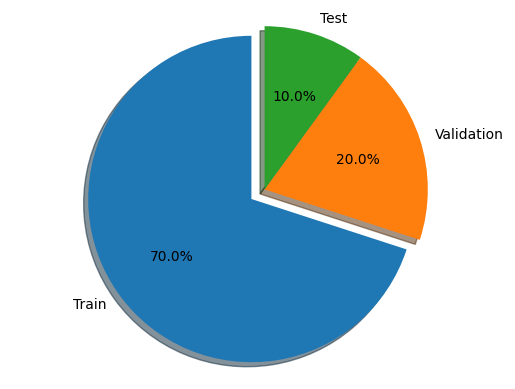

In [4]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Standardizing, tokenizing and indexing the data</b></p>
</div>

First, we need to parse our raw text data and vectorize it.

To keep things simple, we will first limit our vocabulary using the **max_tokens** parameter. We will also limit the length of each sentence using the **sequence_length** parameter.

Each sentence will be standardized, tokenized by word, and then indexed by token.

This will result in a batch of vectors of tokens, stored in a **2D** matrix of shape [(batch_size, **sequence_length**)].

In [5]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [6]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): That's what I expected from Tom.
Target texts (one random sample): [start] C'est ce à quoi je m'attendais, venant de Tom. [end]
Source vectors (one random sample): tf.Tensor(
[ 86  25   2 659  81   8   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   29   17    9  112    4 1386 6316    5   14    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): thats what i expected from tom                         
Target decoded texts (one random sample): [start] cest ce à quoi je mattendais venant de tom [end]                     


In [7]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (122934, 30)
Target vectors (shape): (122934, 31)


# Building the Transformer

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Positional Embedding</b></p>
</div>

In order for our Transformer to be aware of the word order in each sentence, we must add some positional information to the data. **Words must become position-aware.**

First, each token in our vectors will be embedded in a low-dimensional vector (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Secondly, position information (info on where each word stands in the sentence) will be created and added to the embeddings.

This will result in a batch of vectors of positional embeddings, stored in a **3D** matrix of shape [(batch_size, sequence_length, **embedding_size**)].

In [8]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [9]:
# display a random sample before and after embbeding just to test our class

embed_dim = 256

with tf.device('cpu:0'):
    train_source_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="source_embedding",
    ) (train_source_vectors)

    train_target_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="target_embedding",
    ) (train_source_vectors)

    random_sample = random.randint(0, len(train_df))
    print("Source texts (one random sample):", train_source_texts[random_sample])
    print("Target texts (one random sample):", train_target_texts[random_sample])
    print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
    print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
    print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
    print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

Source texts (one random sample): The only thing that Tom drinks is coffee.
Target texts (one random sample): [start] Tom boit uniquement du café. [end]
Source vectors (one random sample): tf.Tensor(
[   5  141  226    9    8 1119    7  346    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   14 1800 6321   41  351    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source embedded vectors (one random sample): tf.Tensor(
[[ 0.02701398 -0.04193989 -0.00741143 ... -0.0180074  -0.05660672
   0.01174691]
 [ 0.05805227 -0.02576329  0.05010702 ...  0.00744344 -0.02804341
   0.07968447]
 [ 0.04485799 -0.07214552 -0.05319118 ... -0.08393973 -0.03537265
   0.06753639]
 ...
 [ 0.01977419  0.03549223  0.01823776 ...  0.05898084 -0.04541779
  -0.04093945]
 

In [10]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (122934, 30, 256)
Target embedded vectors (shape): (122934, 30, 256)


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Attention mechanism</b></p>
</div>

The goal here is to make each of our words (positional embeddings at this point) aware of the other words surrounding them. **Words must become context-aware.**

The implementation of the Attention mechanism involves the following 3 steps : 

- Causal Masking
- Scaled Dot-Product Attention
- Multi-Head Attention

In practice, we could just use **keras.layers.MultiHeadAttention** instead of building it from scratch, but let's do it anyway! 😒

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Causal Masking</b></p>
</div>


Since our words will now be context-aware (aware of words before **and** after them in the sentence), we need a way to mask those *after-words* when needed be (i.e. during training).

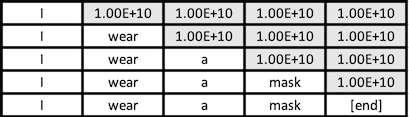

In [11]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [12]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 1.1464477e-02 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 7.8447711e-01  8.3294356e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 7.7977359e-01  6.9458723e-02  3.5143876e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 9.8947430e-01  1.3966084e-01  8.6451900e-01  1.1336994e-01
    -1.0000000e+10]
   [ 8.5250509e-01  6.8273473e-01  5.8840537e-01  9.2376816e-01
     2.0179570e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Scaled Dot-Product Attention</b></p>
</div>

This function is what makes our words context-aware.

We want to compare each word with every other words around them and take note of how *related* they are. Technically, this process can be described as "mapping a query and a set of key-value pairs to an output". It can be summarized as follows :
- We take a **Q**uery of elements.
- For each element in the **Q**uery, we score how much that element is related to every **K**ey (This is done using a compatibility function : MatMul). If needed be, Causal Masking will be applied here.
- Then, we use these relationship scores to weight a sum of **V**alues, which will be our new context-aware representations.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-19.png" width="120">](https://arxiv.org/abs/1706.03762)

In [13]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [14]:
# display the shape of our attention output just to test the function
with tf.device('cpu:0'):
    input = train_source_embedded
    input = tf.expand_dims(input, axis=1)
    print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (122934, 1, 30, 256)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Multi-Head Attention</b></p>
</div>

Multi-head attention was introduced in [Attention is all you need](https://arxiv.org/abs/1706.03762) and is wayyy to technical for me to try and explain here. But basically, it allows for multiple Scaled Dot-Production Attention functions to be run in parallel. 😅
    
[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-20.png" width="200">](https://arxiv.org/abs/1706.03762)

In [15]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = keras.layers.Dense(embed_dim)
        self.k_linear = keras.layers.Dense(embed_dim)
        self.v_linear = keras.layers.Dense(embed_dim)
        self.concat_linear = keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Encoder</b></p>
</div>

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_encoder-zoom.png" width="400">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)

The role of the Encoder is to process the source sentence. Here, no Causal Masking is needed : information is allowed to flow in both directions (words can be aware of words before **and** after them in the sentence).

The Encoder's a pretty generic module that ingests a sentence and learns to turn it into a more useful representation. It can also be used by itself (without the Decoder) for Natural Language Understanding (NLU) tasks like Classification or Named Entity Recognition (NER).

In the Encoder's Multi-Head Self-Attention layer ([Global self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_global_self_attention_layer)), the **Source Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In [16]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Decoder</b></p>
</div>

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_decoder-zoom.png" width="500">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)

The role of the Decoder is to look at the target sentence so far and predict the next word in that sentence.

Contrary to the Encoder, the Decoder is made of two Attention layers. The first Attention layer does a similar job as the Encoder's sole Attention layer, with the important distinction that here, Causal Masking is enabled because, to correctly train our Transformer to predict the next word based on the current word and the previous words in the sentence, we need to mask the *after-words*. Meanwhile, The second Attention layer is much more straight-forward and basically just acts as a bridge that connects the Encoder to the Decoder.

In the Decoder's first Attention layer, the Masked Multi-Head Self-Attention layer ([Causal self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_causal_self_attention_layer)), the **Target Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue. Like mentionned above, Causal Masking is enabled in this layer.

In the Decoder's second Attention layer, the Encoder-Decoder Attention layer ([Cross attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_cross_attention_layer)), the **outputs of the Encoder** are being passed to the **K**ey and **V**alue parameters, with the **outputs of the Decoder's Masked Multi-Head Self-Attention layer** being passed to the **Q**uery parameter.


In [17]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.layer_norm_3 = keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Putting it all together</b></p>
</div>

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

We  turn our data into a *tf.data pipeline* that returns a tuple (Inputs, Outputs) where Inputs is a dict with two keys : **encoder_inputs** (the source sentence) and **decoder_inputs** (the target sentence), and Outputs is a single key : **decoder_outputs** (the target sentence "shifted right").

During training, the fact that our Outputs are offset by one step ahead ("shifted right"), combined with the Causal Masking of the Decoder (Masked Multi-Head Attention layer), ensures that the
predictions for position *i* can depend only on the known outputs at positions less than *i* (no *after-words* visible).

During inference, we'll generate one target word at a time and then feed it back into the Decoder so that it can predict the next word. And so on.

In [18]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [19]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (64, 30)
Decoder Inputs: (64, 30)
Decoder Outputs: (64, 30)


[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_transformer-encoder-decoder.png" width="600">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)


In [20]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_decoder' (of type TransformerDecoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


# Training the Transformer

In [21]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint.weights.h5'
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention_1' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1733419463.364139      69 service.cc:145] XLA service 0x793c24002040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733419463.364200      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:17334

   2/1921 ━━━━━━━━━━━━━━━━━━━━ 2:09 68ms/step - accuracy: 0.1845 - loss: 9.4716       

I0000 00:00:1733419469.991960      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 638/1921 ━━━━━━━━━━━━━━━━━━━━ 1:13 57ms/step - accuracy: 0.7824 - loss: 1.7903

W0000 00:00:1733419506.533305      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1921/1921 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7988 - loss: 1.4625

W0000 00:00:1733419583.851854      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733419588.221074      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1921/1921 ━━━━━━━━━━━━━━━━━━━━ 137s 65ms/step - accuracy: 0.7988 - loss: 1.4624 - val_accuracy: 0.8610 - val_loss: 0.8334 - learning_rate: 0.0010
Epoch 2/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 115s 60ms/step - accuracy: 0.8752 - loss: 0.7626 - val_accuracy: 0.9058 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 3/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 115s 60ms/step - accuracy: 0.9052 - loss: 0.5416 - val_accuracy: 0.9155 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 4/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 113s 59ms/step - accuracy: 0.9159 - loss: 0.4559 - val_accuracy: 0.9174 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 5/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 112s 59ms/step - accuracy: 0.9228 - loss: 0.4018 - val_accuracy: 0.9210 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 6/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 113s 59ms/step - accuracy: 0.9287 - loss: 0.3607 - val_accuracy: 0.9227 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 7/50
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 112s 58ms/step - accuracy: 

# Testing the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.

In [22]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

I enjoy talking with you.
[start] japprécie de parler avec toi [end]

That's fantastic.
[start] cest fantastique [end]

Tom overslept.
[start] tom na pas entendu le réveil [end]

She dyed her hair blonde.
[start] elle sest teint les cheveux en blond [end]

We ask the teacher questions every day.
[start] nous posons chaque jour des questions à linstituteur [end]

The cat is wet.
[start] le chat est mouillé [end]

How did you get here so fast?
[start] comment êtesvous parvenus ici si rapidement [end]

I tried it.
[start] jai essayé [end]

I know that that isn't true.
[start] je sais que ce nest pas vrai [end]

The train is 30 minutes overdue.
[start] le train a trente minutes de retard [end]

The weather is really bad.
[start] le temps est vraiment mauvais [end]

Tom hasn't been living here long.
[start] tom ne vit pas ici longtemps [end]

Do you have any brothers?
[start] avezvous des frères [end]

This data is outdated.
[start] ces données sont [UNK] [end]

I think that it's going to r

# Credits and stuff

- https://arxiv.org/abs/1706.03762

- https://www.tensorflow.org/text/tutorials/transformer

- https://github.com/openai/gpt-2/blob/master/src/model.py

- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

- https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/ch03.html

    - https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb